In [1]:
import tensorflow as tf
import numpy as np
import os
#from PhasedLSTMCell_v1 import *
#from PhasedLSTMCell import *
import time
import sys
import pickle
from rnn_dynamic import *
#from rnn_attentional import * #For the attentional experiment
import scipy
from scipy import spatial
import pandas as pd
import pylab as plt
import seaborn as sns

# Load tensorflow model and get embedding matrix

In [2]:
checkpoint_path = 'checkpoints/rep0-lstm2-256-1-128-adam-10000000000-20170516-161401/best_model/model_best.ckpt-3072000'
max_interactions = 100


# tensorflow model
model_parameters = {}
model_parameters['opt'] = 'adam'
model_parameters['learning_rate'] = 0.01
model_parameters['n_hidden'] = 256
model_parameters['batch_size'] = 128
model_parameters['rnn_type'] = 'lstm2'
model_parameters['rnn_layers'] = 1
model_parameters['dropout'] = 0.0
model_parameters['l2_reg'] = 0.0
model_parameters['type_output'] = 'softmax'
model_parameters['max_steps'] = 3000000
model_parameters['padding'] = 'right'
model_parameters['embedding_size'] = 64
model_parameters['embedding_activation'] = 'linear'
model_parameters['y_length'] = 1
model_parameters['W_emb_init'] = 'W_emb_64'
type_input = 'one-hot'
input_embeddings_size = 0
# Parameters for the attentional model only
model_parameters['attentional_layer'] = 'hidden_state'
model_parameters['attention_weights_activation'] = 'linear'
model_parameters['init_stdev'] = 0.1

model_parameters['n_input'] = 10057
model_parameters['n_output'] = 10057
model_parameters['seq_length'] = max_interactions

model = RNN_dynamic(model_parameters)
model.create_model()

Defined pretrained w_emb
Defined linear embedding


/home/ubuntu/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [3]:
for v in tf.trainable_variables():
    print(v.name)

w_out:0
b_out:0
w_emb:0
rnn/lstm_cell/weights:0
rnn/lstm_cell/biases:0


In [4]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    for v in tf.trainable_variables():
        if v.name == 'w_emb:0':
            print(v.name)
            w_emb = sess.run(v)  
            print(w_emb.shape)
            print(w_emb) # will show you your variable.

w_emb:0
(10057, 64)
[[ 1.02735174  0.06862784 -0.74513423 ...,  1.35585034  0.34104753
  -0.4638297 ]
 [-0.2442378   0.30042219  0.10986914 ...,  1.37415707  0.88000673
  -1.073928  ]
 [-0.14399613  0.58524615 -1.37477016 ...,  0.25727388 -0.24077506
  -0.93148363]
 ..., 
 [-3.43291545 -0.2247842  -1.82929361 ...,  0.80214047  0.1894685
  -0.08208478]
 [-0.75681967  0.00922456  0.73914975 ...,  0.56060237  1.89804471
   1.11131299]
 [ 0.56395811  0.8213532  -2.04135227 ..., -0.54940248  0.560462
   1.55419314]]


# Load movies dataset

In [5]:
start_date_train = '2009-01-01'
date_test = '2014-10-01'
min_seq_length = 5
max_seq_length = 100
movies_min_ratings = 20

#Ratings .dat format: UserID::MovieID::Rating::Timestamp
user_ids = []
movie_ids = []
ratings = []
timestamps = []
dataset_file = "../data/Movielens/ml-20m/ratings.csv"
df = pd.read_csv(dataset_file)
df['userId'] = df['userId'].astype(np.int32)
df['movieId'] = df['movieId'].astype(np.int32)
df['rating'] = df['rating'].astype(np.float16)
df['date'] = pd.to_datetime(df['timestamp'],unit='s')

df_date = df[df.date > start_date_train]

# Filter out movies with less than X ratings
filter_movies = df_date.movieId.value_counts()[(df_date.movieId.value_counts() > movies_min_ratings)].index.values
df_date = df_date[df_date.movieId.isin(filter_movies)]
print('Total number of ratings:' + str(len(df_date)))
print('Number of different users: ' + str(len(df_date['userId'].unique())))
print('Number of different movies: ' + str(len(df_date['movieId'].unique())))
sys.stdout.flush()
# Filter out users with less than X ratings
filter_users = df_date['userId'].value_counts()[(df_date['userId'].value_counts() >= min_seq_length)].index.values
df_date = df_date[df_date.userId.isin(filter_users)]
print('Total number of ratings:' + str(len(df_date)))
print('Number of different users: ' + str(len(df_date['userId'].unique())))
print('Number of different movies: ' + str(len(df_date['movieId'].unique())))

# Build array mapping movie_id --> position in one-hot encoding
movieIds = np.zeros(max(df_date['movieId'].unique()) + 1, np.uint16)
i = 0
for movieId in df_date['movieId'].unique():
    movieIds[movieId] = i
    i += 1

dataset_file = "../data/Movielens/ml-20m/movies.csv"
df_movies = pd.read_csv(dataset_file)
print(len(df_movies.movieId.unique()))
df_movies = df_movies[df_movies.movieId.isin(df_date.movieId.unique())]
print(len(df_movies.movieId.unique()))

# Preprocess year
years = []
for movie_title in df_movies.title:
    year = movie_title[movie_title.find("(")+1:movie_title.find(")")]
    if not year.isdigit():
        year = 0
    years.append(int(year))
df_movies['year'] = years

Total number of ratings:4687202
Number of different users: 36395
Number of different movies: 10057
Total number of ratings:4685946
Number of different users: 35821
Number of different movies: 10057
27278
10057


In [6]:
# Create dictionary dict_movie[position one-hot] = id movilens data set
dict_movies = {}
for i in range(len(movieIds)):
    if movieIds[i] != 0:
        dict_movies[movieIds[i]] = i
dict_movies[0] = 1 # Manually entry, as many items in the array are 0, but this is the one which belongs to an item id

In [7]:
dict_movies[2]

19

In [8]:
i = 0
for movieId in df_date['movieId'].unique():
    print(movieId)
    i += 1
    if i == 10:
        break

1
10
19
32
39
65
110
145
150
153


# T-SNE and PCA Visualizations

In [9]:
# Train T-SNE with all the data
from sklearn.manifold import TSNE

data_tsne = []
movies_ids_sorted = []
for i in range(len(w_emb)):
    data_tsne.append(w_emb[i,:])
    movies_ids_sorted.append(dict_movies[i])

    
data_tsne = np.array(data_tsne)
print(data_tsne.shape)
model_tsn_all = TSNE(n_components=2, random_state=17)
Y_tsn_all = model_tsn_all.fit_transform(data_tsne)

# Create data frame
df_tsne = pd.concat([pd.DataFrame(Y_tsn_all),
                pd.Series(movies_ids_sorted)],
               axis=1)

df_tsne.columns = ['x', 'y', 'movie_id']

titles = []
genres = []
years = []
for movie_id in df_tsne.movie_id:
    titles.append(df_movies[df_movies.movieId == int(movie_id)].title.values[0])
    genres.append(df_movies[df_movies.movieId == int(movie_id)].genres.values[0])
    years.append(df_movies[df_movies.movieId == int(movie_id)].year.values[0])
df_tsne['title'] = titles
df_tsne['genres'] = genres
df_tsne['years'] = years

(10057, 64)


In [10]:
# Train PCA with all the data
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(data_tsne)
X_pca_all = pca.transform(data_tsne)

# Create data frame
df_pca = pd.concat([pd.DataFrame(X_pca_all),
                pd.Series(movies_ids_sorted)],
               axis=1)

df_pca.columns = ['x', 'y', 'movie_id']

titles = []
genres = []
years = []
for movie_id in df_pca.movie_id:
    titles.append(df_movies[df_movies.movieId == int(movie_id)].title.values[0])
    genres.append(df_movies[df_movies.movieId == int(movie_id)].genres.values[0])
    years.append(df_movies[df_movies.movieId == int(movie_id)].year.values[0])
    
df_pca['title'] = titles
df_pca['genres'] = genres
df_pca['years'] = years

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


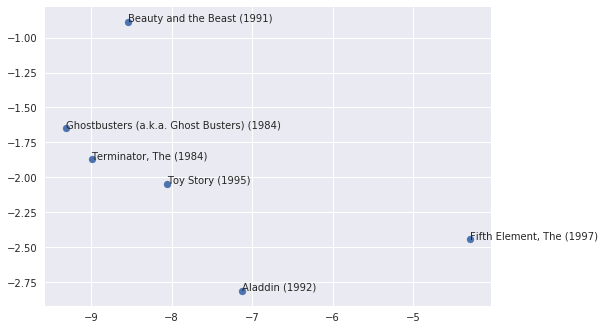

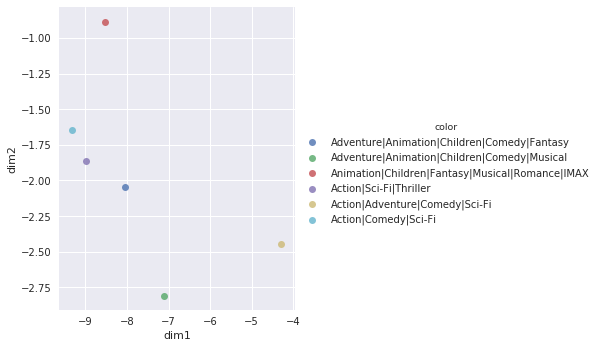

In [11]:
# Visualize n random examples with tsne with annotations
df_show = df_tsne.sample(n=10)

# Visualize specific movies 1(Toy Story), 595(Beautry and Beast), 588(Aladin), 1240(Terminator), 2985(Robocop),  
ids = [1, 595, 588, 1240, 2716, 1527]
ids = [i for i in ids]
df_show = df_tsne[df_tsne.movie_id.isin(ids)]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df_show['x'], df_show['y'])

for i, txt in enumerate(df_show['title']):
    ax.annotate(txt, (df_show['x'].iloc[i], df_show['y'].iloc[i]), fontsize=10)
fig.savefig('scatter_annotations.png')
plt.show()

df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['genres']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.show()

# Plot per year (old/new)

In [12]:
df_tsne['year_category'] = 'Null'
df_tsne.loc[(df_tsne.years > 1900) & (df_tsne.years < 1970),'year_category'] = 'Old (1900-1970)'
#df_tsne.loc[(df_tsne.years > 1950) & (df_tsne.years < 2000),'year_category'] = '1950-1990'
df_tsne.loc[(df_tsne.years > 2000),'year_category'] = 'New (2000 or newer)'

df_pca['year_category'] = 'Null'
df_pca.loc[(df_pca.years > 1900) & (df_pca.years < 1970),'year_category'] = 'Old (1900-1970)'
#df_pca.loc[(df_pca.years > 1950) & (df_pca.years < 2000),'year_category'] = '1950-2000'
df_pca.loc[(df_pca.years > 2000),'year_category'] = 'New (2000 or newer)'

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


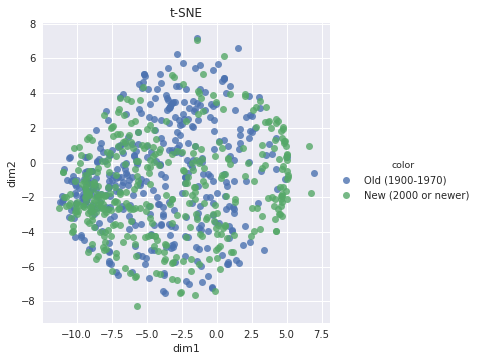

In [13]:
# Using the tsne with all the data
n_samples = 400
df_show1 = df_tsne[df_tsne.year_category == 'Old (1900-1970)'].sample(n=n_samples)
#df_show2 = df_tsne[df_tsne.year_category == '1950-1990'].sample(n=n_samples)
df_show3 = df_tsne[df_tsne.year_category == 'New (2000 or newer)'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show3])

#fig = plt.figure()
#ax = fig.add_subplot(1, 1, 1)

#ax.scatter(df_show['x'], df_show['y'])

#for i, txt in enumerate(df_show['year_category']):
    #ax.annotate(txt, (df_show['x'].iloc[i], df_show['y'].iloc[i]))
#fig.savefig('scatter_annotations.png')
#plt.show()

df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['year_category']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('t-SNE')
plt.show()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


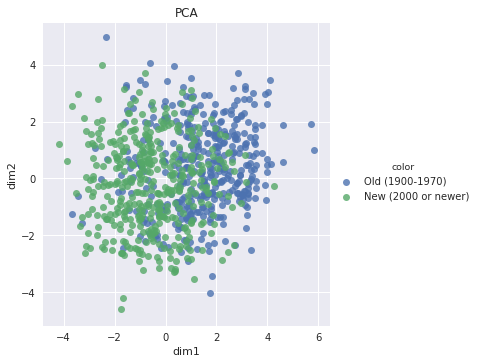

In [14]:
# Using the pca with all the data
n_samples = 400
df_show1 = df_pca[df_pca.year_category == 'Old (1900-1970)'].sample(n=n_samples)
#df_show2 = df_pca[df_pca.year_category == '1960-1990'].sample(n=n_samples)
df_show3 = df_pca[df_pca.year_category == 'New (2000 or newer)'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show3])

#fig = plt.figure()
#ax = fig.add_subplot(1, 1, 1)

#ax.scatter(df_show['x'], df_show['y'])

#for i, txt in enumerate(df_show['year_category']):
    #ax.annotate(txt, (df_show['x'].iloc[i], df_show['y'].iloc[i]))
#fig.savefig('scatter_annotations.png')
#plt.show()

df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['year_category']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('PCA')
plt.show()

(800, 64)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


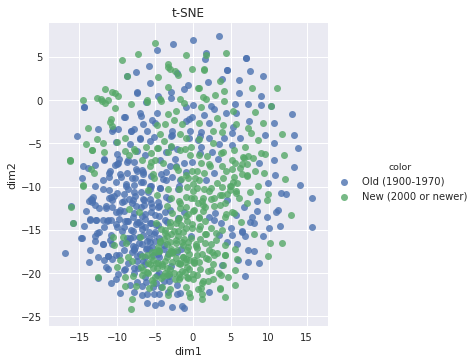

In [15]:
# Recomputing tsne for the selected samples
n_samples = 400
df_show1 = df_tsne[df_tsne.year_category == 'Old (1900-1970)'].sample(n=n_samples)
#df_show2 = df_tsne[df_tsne.year_category == '1950-1990'].sample(n=n_samples)
df_show3 = df_tsne[df_tsne.year_category == 'New (2000 or newer)'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show3])

item_vectors = []
for movie_id in df_show.movie_id:
    position = movieIds[movie_id]
    vector = w_emb[position,:]
    item_vectors.append(vector)
    
item_vectors = np.array(item_vectors)    
print(item_vectors.shape)

model_tsn_1 = TSNE(n_components=2, random_state=8)
Y_tsn_1 = model_tsn_1.fit_transform(item_vectors)


df_show['x_1'] = Y_tsn_1[:, 0]
df_show['y_1'] = Y_tsn_1[:, 1]


df_plot = pd.DataFrame(dict(dim1=df_show['x_1'], dim2=df_show['y_1'], color=df_show['year_category']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('t-SNE')
plt.show()

(800, 64)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


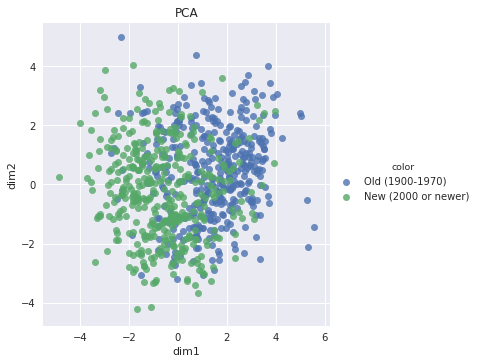

In [16]:
# Recomputing pca for the selected samples
n_samples = 400
df_show1 = df_pca[df_pca.year_category == 'Old (1900-1970)'].sample(n=n_samples)
#df_show2 = df_pca[df_pca.year_category == '1960-1990'].sample(n=n_samples)
df_show3 = df_pca[df_pca.year_category == 'New (2000 or newer)'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show3])

item_vectors = []
for movie_id in df_show.movie_id:
    position = movieIds[movie_id]
    vector = w_emb[position,:]
    item_vectors.append(vector)
    
item_vectors = np.array(item_vectors)    
print(item_vectors.shape)

X_pca_1 = PCA(n_components=2)
X_pca_1.fit(item_vectors)
X_pca_1 = pca.transform(item_vectors)


df_show['x_1'] = X_pca_1[:, 0]
df_show['y_1'] = X_pca_1[:, 1]


df_plot = pd.DataFrame(dict(dim1=df_show['x_1'], dim2=df_show['y_1'], color=df_show['year_category']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('PCA')
plt.show()



# Plot per genres

In [17]:
romance_genres = ['Comedy|Romance', 'Comedy|Musical|Romance', 'Musical|Romance', 'Fantasy|Musical|Romance', 'Romance', 'Comedy|Romance|Thriller',
                'Fantasy|Romance', 'Drama|Romance']
children_genres = ['Animation|Children|Fantasy', 'Action|Animation|Children|Comedy', 'Adventure|Animation|Children|Fantasy',
                  'Animation|Children', 'Adventure|Children|Fantasy', 'Action|Animation|Children', 'Adventure|Children',
                  'Adventure|Animation|Children', 'Children|Comedy|Fantasy', 'Children|Fantasy', 'Action|Children',
                  'Action|Children|Fantasy', 'Children', 'Animation|Children|Fantasy|IMAX', 'Action|Adventure|Children|IMAX',
                  'Adventure|Children|Comedy|Fantasy|Mystery', 'Adventure|Children|Drama|Fantasy', 'Animation|Children|Fantasy|IMAX',
                  'Children|Comedy']
horror_genres = ['Horror|Mystery|Thriller', 'Horror', 'Horror|Thriller', 'Action|Horror', 'Drama|Horror|Thriller'
                'Drama|Horror', 'Crime|Horror|Thriller', 'Action|Crime|Horror', 'Crime|Horror', 'Crime|Horror|Mystery'
                'Crime|Drama|Horror', ]

In [18]:
df_tsne['genre_1'] = 'Null'
df_tsne.loc[df_tsne.genres.isin(romance_genres), 'genre_1'] = 'Romance'
df_tsne.loc[df_tsne.genres.isin(children_genres), 'genre_1'] = 'Children'
df_tsne.loc[df_tsne.genres.isin(horror_genres), 'genre_1'] = 'Horror'


df_pca['genre_1'] = 'Null'
df_pca.loc[df_pca.genres.isin(romance_genres), 'genre_1'] = 'Romance'
df_pca.loc[df_pca.genres.isin(children_genres), 'genre_1'] = 'Children'
df_pca.loc[df_pca.genres.isin(horror_genres), 'genre_1'] = 'Horror'

                         



In [19]:
print(len(df_tsne[df_tsne.genre_1 == 'Romance']))
print(len(df_tsne[df_tsne.genre_1 == 'Children']))
print(len(df_tsne[df_tsne.genre_1 == 'Horror']))

820
212
415


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


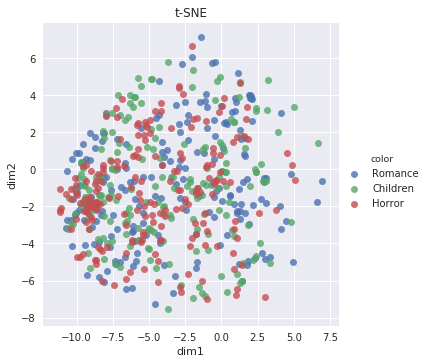

In [20]:
# Using the tsne with all the data
n_samples = 200
df_show1 = df_tsne[df_tsne.genre_1 == 'Romance'].sample(n=n_samples)
df_show2 = df_tsne[df_tsne.genre_1 == 'Children'].sample(n=n_samples)
df_show3 = df_tsne[df_tsne.genre_1 == 'Horror'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show2, df_show3])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['genre_1']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('t-SNE')
plt.show()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


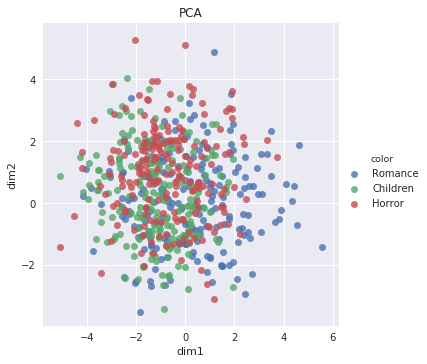

In [21]:
# Using the pca with all the data
n_samples = 200
df_show1 = df_pca[df_tsne.genre_1 == 'Romance'].sample(n=n_samples)
df_show2 = df_pca[df_tsne.genre_1 == 'Children'].sample(n=n_samples)
df_show3 = df_pca[df_tsne.genre_1 == 'Horror'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show2, df_show3])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['genre_1']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('PCA')
plt.show()

(600, 64)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


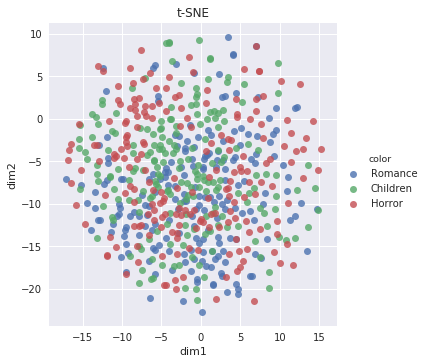

In [22]:
# Recomputing tsne for the selected samples
n_samples = 200
df_show1 = df_tsne[df_tsne.genre_1 == 'Romance'].sample(n=n_samples)
df_show2 = df_tsne[df_tsne.genre_1 == 'Children'].sample(n=n_samples)
df_show3 = df_tsne[df_tsne.genre_1 == 'Horror'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show2, df_show3])

item_vectors = []
for movie_id in df_show.movie_id:
    position = movieIds[movie_id]
    vector = w_emb[position,:]
    item_vectors.append(vector)
    
item_vectors = np.array(item_vectors)    
print(item_vectors.shape)

model_tsn_1 = TSNE(n_components=2, random_state=8)
Y_tsn_1 = model_tsn_1.fit_transform(item_vectors)


df_show['x_1'] = Y_tsn_1[:, 0]
df_show['y_1'] = Y_tsn_1[:, 1]


df_plot = pd.DataFrame(dict(dim1=df_show['x_1'], dim2=df_show['y_1'], color=df_show['genre_1']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('t-SNE')
plt.show()

(600, 64)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


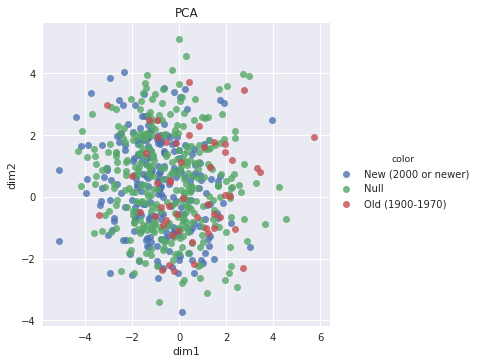

In [23]:
# Recomputing pca for the selected samples
n_samples = 200
df_show1 = df_pca[df_tsne.genre_1 == 'Romance'].sample(n=n_samples)
df_show2 = df_pca[df_tsne.genre_1 == 'Children'].sample(n=n_samples)
df_show3 = df_pca[df_tsne.genre_1 == 'Horror'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show2, df_show3])

item_vectors = []
for movie_id in df_show.movie_id:
    position = movieIds[movie_id]
    vector = w_emb[position,:]
    item_vectors.append(vector)
    
item_vectors = np.array(item_vectors)    
print(item_vectors.shape)

X_pca_1 = PCA(n_components=2)
X_pca_1.fit(item_vectors)
X_pca_1 = pca.transform(item_vectors)


df_show['x_1'] = X_pca_1[:, 0]
df_show['y_1'] = X_pca_1[:, 1]


df_plot = pd.DataFrame(dict(dim1=df_show['x_1'], dim2=df_show['y_1'], color=df_show['year_category']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('PCA')
plt.show()



# Plot one Genre vs Other

In [24]:
# Drama vs Comedy 

drama_genres = ['Drama', 'Action|Crime|Drama', 'Drama|War', 'Crime|Drama', 'Drama|Thriller', 'Adventure|Drama',
               'Crime|Drama|Mystery', 'Drama|Mystery', 'Action|Drama|War', 'Drama|Thriller|War']
comedy_genres = ['Adventure|Comedy', 'Comedy|Romance', 'Comedy', 'Children|Comedy', 'Action|Comedy', 'Animation|Comedy',
                'Action|Comedy|IMAX']


df_tsne['genre_2'] = 'Null'
df_tsne.loc[df_tsne.genres.isin(drama_genres), 'genre_2'] = 'Drama'
df_tsne.loc[df_tsne.genres.isin(comedy_genres), 'genre_2'] = 'Comedy'



df_pca['genre_2'] = 'Null'
df_pca.loc[df_pca.genres.isin(drama_genres), 'genre_2'] = 'Drama'
df_pca.loc[df_pca.genres.isin(comedy_genres), 'genre_2'] = 'Comedy'

In [25]:
#for genre in df_pca.genres.unique():
    #if 'Comedy' in genre:
        #print(genre)

print(len(df_tsne[df_tsne.genre_2 == 'Drama']))
print(len(df_tsne[df_tsne.genre_2 == 'Comedy']))


1909
1314


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


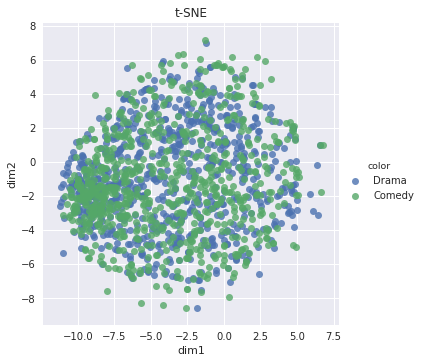

In [61]:
# Using the tsne with all the data
n_samples = 800
df_show1 = df_tsne[df_tsne.genre_2 == 'Drama'].sample(n=n_samples)
df_show2 = df_tsne[df_tsne.genre_2 == 'Comedy'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show2])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['genre_2']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('t-SNE')
plt.show()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


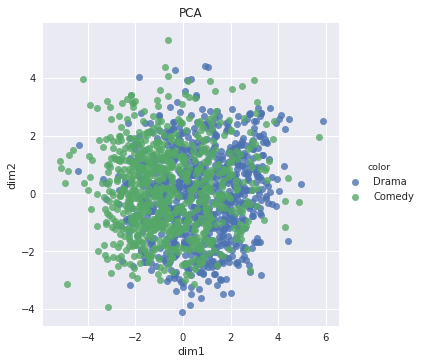

In [27]:
# Using the pca with all the data
n_samples = 800
df_show1 = df_pca[df_tsne.genre_2 == 'Drama'].sample(n=n_samples)
df_show2 = df_pca[df_tsne.genre_2 == 'Comedy'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show2])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['genre_2']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('PCA')
plt.show()

(1600, 64)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


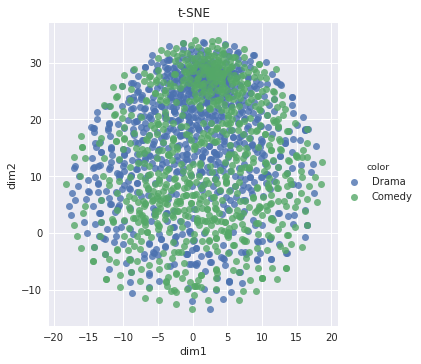

In [28]:
# Recomputing tsne for the selected samples
n_samples = 800
df_show1 = df_tsne[df_tsne.genre_2 == 'Drama'].sample(n=n_samples)
df_show2 = df_tsne[df_tsne.genre_2 == 'Comedy'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show2])

item_vectors = []
for movie_id in df_show.movie_id:
    position = movieIds[movie_id]
    vector = w_emb[position,:]
    item_vectors.append(vector)
    
item_vectors = np.array(item_vectors)    
print(item_vectors.shape)

model_tsn_1 = TSNE(n_components=2, random_state=8)
Y_tsn_1 = model_tsn_1.fit_transform(item_vectors)


df_show['x_1'] = Y_tsn_1[:, 0]
df_show['y_1'] = Y_tsn_1[:, 1]


df_plot = pd.DataFrame(dict(dim1=df_show['x_1'], dim2=df_show['y_1'], color=df_show['genre_2']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('t-SNE')
plt.show()

(1600, 64)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


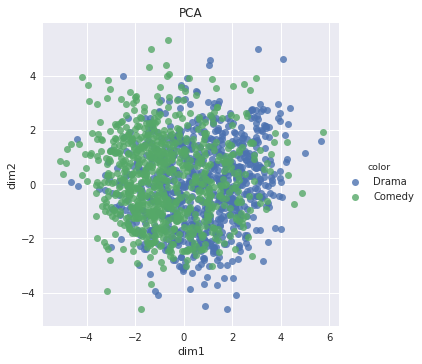

In [29]:
# Recomputing pca for the selected samples
n_samples = 800
df_show1 = df_pca[df_tsne.genre_2 == 'Drama'].sample(n=n_samples)
df_show2 = df_pca[df_tsne.genre_2 == 'Comedy'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show2])

item_vectors = []
for movie_id in df_show.movie_id:
    position = movieIds[movie_id]
    vector = w_emb[position,:]
    item_vectors.append(vector)
    
item_vectors = np.array(item_vectors)    
print(item_vectors.shape)

X_pca_1 = PCA(n_components=2)
X_pca_1.fit(item_vectors)
X_pca_1 = pca.transform(item_vectors)


df_show['x_1'] = X_pca_1[:, 0]
df_show['y_1'] = X_pca_1[:, 1]


df_plot = pd.DataFrame(dict(dim1=df_show['x_1'], dim2=df_show['y_1'], color=df_show['genre_2']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('PCA')
plt.show()



# Plots more concrete genres

In [30]:
# War vs Musical 

drama_war_action_genres = ['Drama|War', 'Action|Drama|War']
comedy_romance_genres = ['Comedy|Drama|Romance']
children_comedy = ['Children|Comedy', 'Children|Comedy|Fantasy']
western_genres = ['Western']


df_tsne['genre_3'] = 'Null'
df_tsne.loc[df_tsne.genres.isin(drama_war_action_genres), 'genre_3'] = 'Drama|War|Action'
df_tsne.loc[df_tsne.genres.isin(comedy_romance_genres), 'genre_3'] = 'Comedy|Romance'
df_tsne.loc[df_tsne.genres.isin(children_comedy), 'genre_3'] = 'Children|Comedy'
df_tsne.loc[df_tsne.genres.isin(western_genres), 'genre_3'] = 'Western'



df_pca['genre_3'] = 'Null'
df_pca.loc[df_pca.genres.isin(drama_war_action_genres), 'genre_3'] = 'Drama|War|Action'
df_pca.loc[df_pca.genres.isin(comedy_romance_genres), 'genre_3'] = 'Comedy|Romance'
df_pca.loc[df_pca.genres.isin(children_comedy), 'genre_3'] = 'Children|Comedy'
df_pca.loc[df_pca.genres.isin(western_genres), 'genre_3'] = 'Western'



In [31]:

print(len(df_tsne[df_tsne.genre_3 == 'Drama|War|Action']))
print(len(df_tsne[df_tsne.genre_3 == 'Comedy|Romance']))
print(len(df_tsne[df_tsne.genre_3 == 'Children|Comedy']))
print(len(df_tsne[df_tsne.genre_3 == 'Western']))

192
292
94
41


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


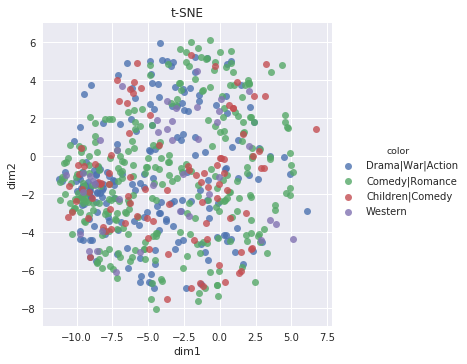

In [62]:
# Using the tsne with all the data
n_samples = 40
df_show1 = df_tsne[df_tsne.genre_3 == 'Drama|War|Action'].sample(n=192)
df_show2 = df_tsne[df_tsne.genre_3 == 'Comedy|Romance'].sample(n=292)
df_show3 = df_tsne[df_tsne.genre_3 == 'Children|Comedy'].sample(n=94)
df_show4 = df_tsne[df_tsne.genre_3 == 'Western'].sample(n=41)
df_show = pd.concat([df_show1, df_show2 ,df_show3, df_show4])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['genre_3']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('t-SNE')
plt.show()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


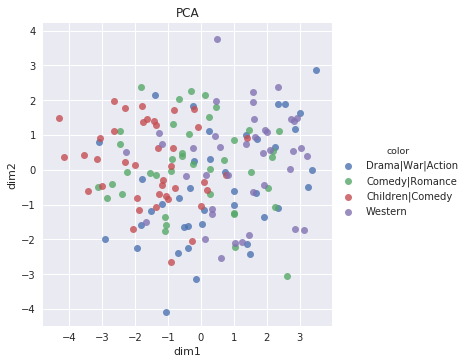

In [33]:
# Using the pca with all the data
n_samples = 40
df_show1 = df_pca[df_pca.genre_3 == 'Drama|War|Action'].sample(n=n_samples)
df_show2 = df_pca[df_pca.genre_3 == 'Comedy|Romance'].sample(n=n_samples)
df_show3 = df_pca[df_pca.genre_3 == 'Children|Comedy'].sample(n=n_samples)
df_show4 = df_pca[df_pca.genre_3 == 'Western'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show2 ,df_show3, df_show4])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['genre_3']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('PCA')
plt.show()


(619, 64)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


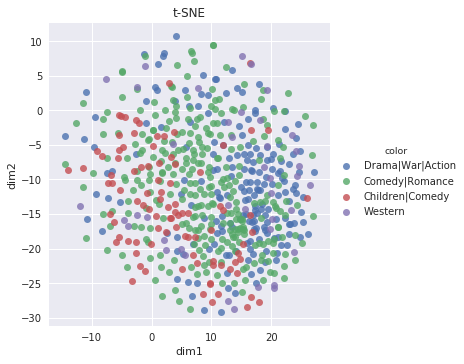

In [34]:
# Recomputing tsne for the selected samples
n_samples = 40
df_show1 = df_tsne[df_tsne.genre_3 == 'Drama|War|Action'].sample(n=192)
df_show2 = df_tsne[df_tsne.genre_3 == 'Comedy|Romance'].sample(n=292)
df_show3 = df_tsne[df_tsne.genre_3 == 'Children|Comedy'].sample(n=94)
df_show4 = df_tsne[df_tsne.genre_3 == 'Western'].sample(n=41)
df_show = pd.concat([df_show1, df_show2 ,df_show3, df_show4])

item_vectors = []
for movie_id in df_show.movie_id:
    position = movieIds[movie_id]
    vector = w_emb[position,:]
    item_vectors.append(vector)
    
item_vectors = np.array(item_vectors)    
print(item_vectors.shape)

model_tsn_1 = TSNE(n_components=2, random_state=8)
Y_tsn_1 = model_tsn_1.fit_transform(item_vectors)


df_show['x_1'] = Y_tsn_1[:, 0]
df_show['y_1'] = Y_tsn_1[:, 1]


df_plot = pd.DataFrame(dict(dim1=df_show['x_1'], dim2=df_show['y_1'], color=df_show['genre_3']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('t-SNE')
plt.show()

(160, 64)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


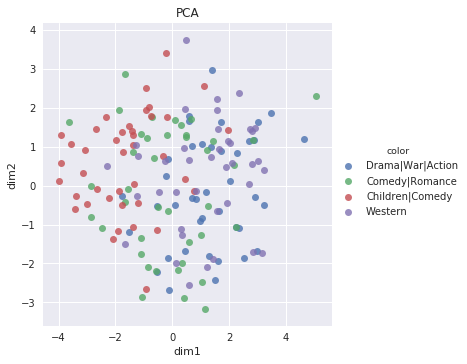

In [35]:
# Recomputing pca for the selected samples
n_samples = 40
df_show1 = df_pca[df_pca.genre_3 == 'Drama|War|Action'].sample(n=n_samples)
df_show2 = df_pca[df_pca.genre_3 == 'Comedy|Romance'].sample(n=n_samples)
df_show3 = df_pca[df_pca.genre_3 == 'Children|Comedy'].sample(n=n_samples)
df_show4 = df_pca[df_pca.genre_3 == 'Western'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show2 ,df_show3, df_show4])

item_vectors = []
for movie_id in df_show.movie_id:
    position = movieIds[movie_id]
    vector = w_emb[position,:]
    item_vectors.append(vector)
    
item_vectors = np.array(item_vectors)    
print(item_vectors.shape)

X_pca_1 = PCA(n_components=2)
X_pca_1.fit(item_vectors)
X_pca_1 = pca.transform(item_vectors)


df_show['x_1'] = X_pca_1[:, 0]
df_show['y_1'] = X_pca_1[:, 1]


df_plot = pd.DataFrame(dict(dim1=df_show['x_1'], dim2=df_show['y_1'], color=df_show['genre_3']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('PCA')
plt.show()



# Plots for specific Movies

In [12]:
df_tsne['movie_id'] = df_tsne['movie_id'].astype(str) 
df_pca['movie_id'] = df_pca['movie_id'].astype(str) 

In [37]:
# Find movie
df_tsne[df_tsne.title.str.contains('Scream')]

,x,y,movie_id,title,genres,years,year_category,genre_1,genre_2,genre_3
1510,-1.539362,-5.875756,1407,Scream (1996),Comedy|Horror|Mystery|Thriller,1996,Null,Null,Null,Null
1650,0.043969,5.649248,1717,Scream 2 (1997),Comedy|Horror|Mystery|Thriller,1997,Null,Null,Null,Null
2591,3.496567,-0.095044,76,Screamers (1995),Action|Sci-Fi|Thriller,1995,Null,Null,Null,Null
2633,-0.047804,-6.507050,3273,Scream 3 (2000),Comedy|Horror|Mystery|Thriller,2000,Null,Null,Null,Null
3532,-8.421305,-1.100118,86295,Scream 4 (2011),Comedy|Horror|Mystery|Thriller,2011,New (2000 or newer),Null,Null,Null
4109,-2.069739,-1.180236,33495,Kicking & Screaming (2005),Comedy,2005,New (2000 or newer),Null,Comedy,Null
4110,-6.682387,1.854970,33930,Man with the Screaming Brain (2005),Adventure|Comedy|Sci-Fi,2005,New (2000 or newer),Null,Null,Null
4284,-5.680899,-3.770457,66789,Screamers: The Hunting (2009),Sci-Fi|Thriller,2009,New (2000 or newer),Null,Null,Null
6417,-5.729594,-2.076674,72,Kicking and Screaming (1995),Comedy|Drama,1995,Null,Null,Null,Null


In [38]:
# Some sagas

star_wars_movies = [260, 1196, 1210, 2628, 5378, 33493]
lord_of_the_rings_movies = [4993, 5952, 7153, 106489, 98809, 118696]
saw_movies = [8957, 39446, 48877, 55577, 63436, 72129, 81535]
#toy_story_movies = [78499, 3114, 1]
rocky_movies = [1954, 2409, 2410, 2411, 2412, 89045]
harry_potter_movies = [81834, 88125, 8368, 4896, 54001, 69844, 40815, 5816]
scream_movies = [86295, 1407, 1717, 3273]
star_wars_movies = [str(i) for i in star_wars_movies]
lord_of_the_rings_movies = [str(i) for i in lord_of_the_rings_movies]
saw_movies = [str(i) for i in saw_movies]
#toy_story_movies = [str(i) for i in toy_story_movies]
rocky_movies = [str(i) for i in rocky_movies]
harry_potter_movies = [str(i) for i in harry_potter_movies]
scream_movies = [str(i) for i in scream_movies]



df_tsne['saga'] = 'Null'
df_tsne.loc[df_tsne.movie_id.isin(star_wars_movies), 'saga'] = 'Star Wars'
df_tsne.loc[df_tsne.movie_id.isin(lord_of_the_rings_movies), 'saga'] = 'Lord of the Rings'
df_tsne.loc[df_tsne.movie_id.isin(saw_movies), 'saga'] = 'Saw'
#df_tsne.loc[df_tsne.movie_id.isin(toy_story_movies), 'saga'] = 'Toy Story'
df_tsne.loc[df_tsne.movie_id.isin(rocky_movies), 'saga'] = 'Rocky'
df_tsne.loc[df_tsne.movie_id.isin(harry_potter_movies), 'saga'] = 'Harry Potter'
df_tsne.loc[df_tsne.movie_id.isin(scream_movies), 'saga'] = 'Scream'



df_pca['saga'] = 'Null'
df_pca.loc[df_pca.movie_id.isin(star_wars_movies), 'saga'] = 'Star Wars'
df_pca.loc[df_pca.movie_id.isin(lord_of_the_rings_movies), 'saga'] = 'Lord of the Rings'
df_pca.loc[df_pca.movie_id.isin(saw_movies), 'saga'] = 'Saw'
#df_pca.loc[df_pca.movie_id.isin(toy_story_movies), 'saga'] = 'Toy Story'
df_pca.loc[df_pca.movie_id.isin(rocky_movies), 'saga'] = 'Rocky'
df_pca.loc[df_pca.movie_id.isin(harry_potter_movies), 'saga'] = 'Harry Potter'
df_pca.loc[df_pca.movie_id.isin(scream_movies), 'saga'] = 'Scream'


len_star_wars = len(df_tsne[df_tsne.saga == 'Star Wars'])
len_lord_of_the_rings = len(df_tsne[df_tsne.saga == 'Lord of the Rings'])
len_saw = len(df_tsne[df_tsne.saga == 'Saw'])
#len_toy_story = len(df_tsne[df_tsne.saga == 'Toy Story'])
len_rocky = len(df_tsne[df_tsne.saga == 'Rocky'])
len_harrypotter = len(df_tsne[df_tsne.saga == 'Harry Potter'])
len_scream = len(df_tsne[df_tsne.saga == 'Scream'])
print(len_star_wars)
print(len_lord_of_the_rings)
print(len_saw)
#print(len_toy_story)
print(len_rocky)
print(len_harrypotter)
print(len_scream)

6
6
7
6
8
4


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


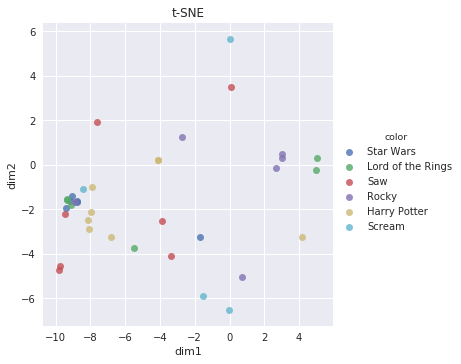

In [39]:
# Using the tsne with all the data
n_samples = 40
df_show1 = df_tsne[df_tsne.saga == 'Star Wars'].sample(n=len_star_wars)
df_show2 = df_tsne[df_tsne.saga == 'Lord of the Rings'].sample(n=len_lord_of_the_rings)
df_show3 = df_tsne[df_tsne.saga == 'Saw'].sample(n=len_saw)
#df_show4 = df_tsne[df_tsne.saga == 'Toy Story'].sample(n=len_toy_story)
df_show5 = df_tsne[df_tsne.saga == 'Rocky'].sample(n=len_rocky)
df_show6 = df_tsne[df_tsne.saga == 'Harry Potter'].sample(n=len_harrypotter)
df_show7 = df_tsne[df_tsne.saga == 'Scream'].sample(n=len_scream)
df_show = pd.concat([df_show1, df_show2 ,df_show3, df_show5, df_show6, df_show7])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['saga']))
ax = sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('t-SNE')
plt.show()



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


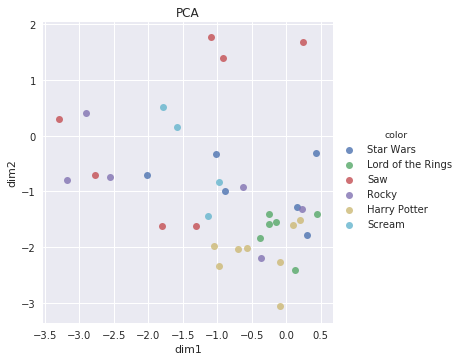

In [40]:
# Using the pca with all the data
n_samples = 40
df_show1 = df_pca[df_pca.saga == 'Star Wars'].sample(n=len_star_wars)
df_show2 = df_pca[df_pca.saga == 'Lord of the Rings'].sample(n=len_lord_of_the_rings)
df_show3 = df_pca[df_pca.saga == 'Saw'].sample(n=len_saw)
#df_show4 = df_pca[df_pca.saga == 'Toy Story'].sample(n=len_toy_story)
df_show5 = df_pca[df_pca.saga == 'Rocky'].sample(n=len_rocky)
df_show6 = df_pca[df_pca.saga == 'Harry Potter'].sample(n=len_harrypotter)
df_show7 = df_pca[df_pca.saga == 'Scream'].sample(n=len_scream)
df_show = pd.concat([df_show1, df_show2 ,df_show3, df_show5, df_show6, df_show7])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['saga']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('PCA')
plt.show()

# Plot some of items that are in a windows size of 5 in order

In [59]:
movie_seq1 = ['79132', '2571', '2959'] # 156 ocurrences -> Inception (2010) Matrix, The (1999) Fight Club (1999) 156
movie_seq2 = ['4886', '4306', '6377'] # 97 ocurrences -> Monsters, Inc. (2001), Shrek (2001), Finding Nemo (2003)
movie_seq3 = ['527', '858', '318'] # 104 ocurrences -> Schindler's List (1993), Godfather, The (1972), Shawshank Redemption, The (1994)

df_tsne['freq_seq'] = 'Null'
df_tsne.loc[df_tsne.movie_id.isin(seq1_movies), 'freq_seq'] = 'Inception (2010) Matrix, The (1999) Fight Club (1999)'
df_tsne.loc[df_tsne.movie_id.isin(seq2_movies), 'freq_seq'] = 'Monsters, Inc. (2001), Shrek (2001), Finding Nemo (2003)'
df_tsne.loc[df_tsne.movie_id.isin(seq3_movies), 'freq_seq'] = 'Schindlers List (1993), Godfather, The (1972), Shawshank Redemption, The (1994)'


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


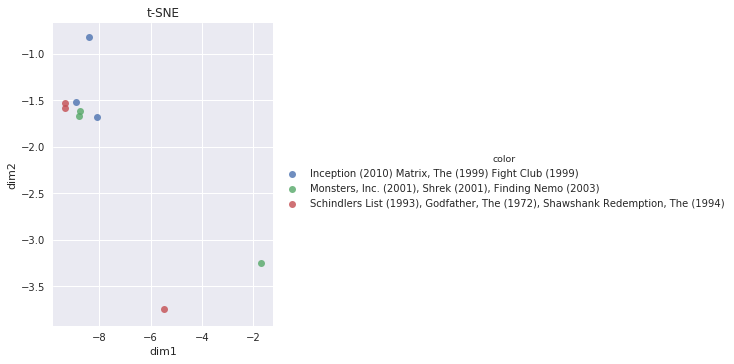

In [60]:
# Using the tsne with all the data
n_samples = 40
df_show1 = df_tsne[df_tsne.freq_seq == 'Inception (2010) Matrix, The (1999) Fight Club (1999)'].sample(n=3)
df_show2 = df_tsne[df_tsne.freq_seq == 'Monsters, Inc. (2001), Shrek (2001), Finding Nemo (2003)'].sample(n=3)
df_show3 = df_tsne[df_tsne.freq_seq == 'Schindlers List (1993), Godfather, The (1972), Shawshank Redemption, The (1994)'].sample(n=3)
df_show = pd.concat([df_show1 ,df_show2, df_show3])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['freq_seq']))
ax = sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('t-SNE')
plt.show()

# Plot some of the top frequent sequences in the data

In [57]:
seq1_movies = ['6016', '58559', '2959'] # 69 ocurrences (Fight Club (1999), City of God (Cidade de Deus) (2002), Dark Knight, The (2008))
seq2_movies = ['260', '1196', '1210'] # 439 ocurrences (Star wars)
seq3_movies = ['4993', '7153', '5952'] # 1435 ocurrences (Lord of the rings)
seq4_movies = ['5418', '8665', '54286'] # 372 ocurrences (Bourne)
seq5_movies = ['113278', '110553', '102154'] #(Batman, superman, spiderman)
seq6_movies = ['1', '3114', '78499'] #(Toy Story)
seq7_movies = ['2571', '6365', '6934'] #(Matrix)


df_tsne['freq_seq'] = 'Null'
df_tsne.loc[df_tsne.movie_id.isin(seq1_movies), 'freq_seq'] = 'Frequent sequence 1'
df_tsne.loc[df_tsne.movie_id.isin(seq2_movies), 'freq_seq'] = 'Star Wars'
df_tsne.loc[df_tsne.movie_id.isin(seq3_movies), 'freq_seq'] = 'Lord of the Rings'
df_tsne.loc[df_tsne.movie_id.isin(seq4_movies), 'freq_seq'] = 'Bourne'
df_tsne.loc[df_tsne.movie_id.isin(seq5_movies), 'freq_seq'] = 'Batman, superman, spiderman'
df_tsne.loc[df_tsne.movie_id.isin(seq6_movies), 'freq_seq'] = 'Toy Story'



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


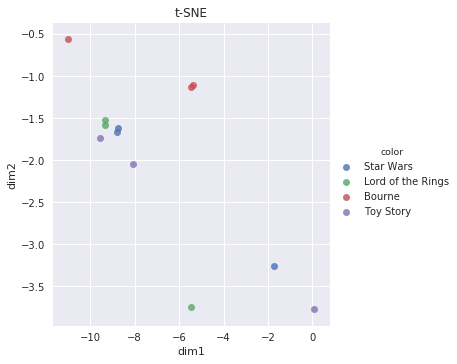

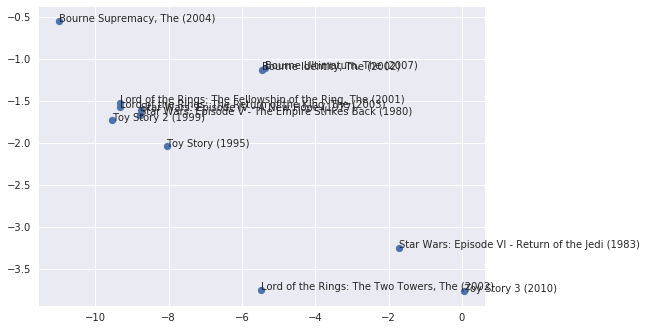

In [58]:
# Using the tsne with all the data
n_samples = 40
df_show1 = df_tsne[df_tsne.freq_seq == 'Frequent sequence 1'].sample(n=3)
df_show2 = df_tsne[df_tsne.freq_seq == 'Star Wars'].sample(n=3)
df_show3 = df_tsne[df_tsne.freq_seq == 'Lord of the Rings'].sample(n=3)
df_show4 = df_tsne[df_tsne.freq_seq == 'Bourne'].sample(n=3)
df_show5 = df_tsne[df_tsne.freq_seq == 'Batman, superman, spiderman'].sample(n=3)
df_show6 = df_tsne[df_tsne.freq_seq == 'Toy Story'].sample(n=3)
df_show = pd.concat([df_show2 ,df_show3, df_show4, df_show6])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['freq_seq']))
ax = sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('t-SNE')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df_show['x'], df_show['y'])

for i, txt in enumerate(df_show['title']):
    ax.annotate(txt, (df_show['x'].iloc[i], df_show['y'].iloc[i]), fontsize=10)
fig.savefig('scatter_annotations.png')
plt.show()

# Better Experiment: Select a movie, and see which movies are close, print intensity in the scatter acording to the number of co-ocurrences, so the closest movies should have higher intensity

In [13]:
# Create movie sequence
grouped = df_date.groupby('userId')

movie_sequences = []
i = 0
for name, group in grouped:
    # sorting by ratings
    movie_sequences.append(group.sort_values(['rating', 'date']).movieId.values.astype(str).tolist())
    i += 1

In [14]:
# Compute number of times that a movie appears etween a windows size given another movie (coocurrences)

def count_coocurrences(movie_A, movie_B, sequences, windows_size):
    count = 0
    for seq in sequences:
        if (movie_A in seq) and (movie_B in seq):
            idx_A = seq.index(movie_A)
            idx_B = seq.index(movie_B)
            if np.abs(idx_A - idx_B) <= windows_size:
                count += 1
    return count
        

0.570103610957 -1.38039785172


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


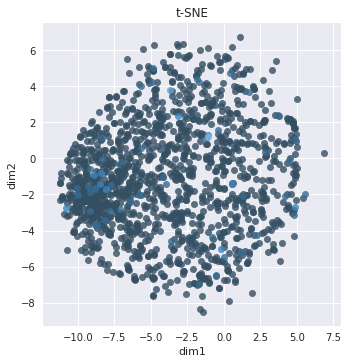

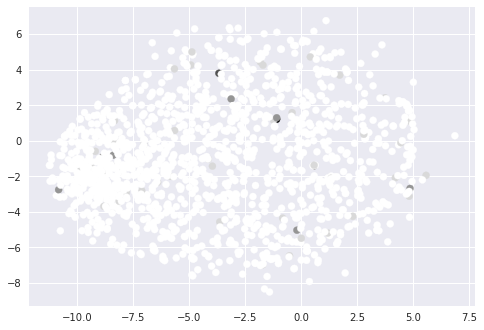

In [27]:
#primary_movies = ['58559', '318', '2571', '2959', '79132', '296', '356', '4993', '7153', '5952', '57706', '40494', '52378', '32022', '74657', '3648', '71817', '73879', '5003', '2098']
primary_movies = ['93748']

for p in primary_movies:
    w_size = 10
    primary_movie = p
    secondary_movies = df_tsne.movie_id.sample(1500)
    co_ocurrences = {}
    for m in secondary_movies:
        co_ocurrences[m] = 0
    for seq in movie_sequences:
        if primary_movie in seq:
            idx_A = seq.index(primary_movie)
            for m in secondary_movies:
                if m in seq:
                    idx_B = seq.index(m)
                    if np.abs(idx_A - idx_B) <= w_size:
                        co_ocurrences[m] += 1

    df_show1 = df_tsne[df_tsne.movie_id.isin(secondary_movies)]
    df_show2 = df_tsne[df_tsne.movie_id == p]
    x_movie = df_show2['x'].values[0]
    y_movie = df_show2['y'].values[0]
    df_show = pd.concat([df_show1 ,df_show2])
    df_show['co-ocurrences'] = 0
    df_show['co-ocurrences'] = df_show['movie_id'].map(co_ocurrences)
    df_show.loc[df_tsne.movie_id == p, 'co-ocurrences'] = 1
    df_show['is_item'] = 0
    df_show.loc[df_tsne.movie_id == p, 'is_item'] = 1
    print(x_movie, y_movie)

    from sklearn import preprocessing

    x = df_show['co-ocurrences'] #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)


    df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=x_scaled))
    ax = sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', palette="Blues_d", fit_reg=False, legend=False)
    #ax.fig.text(x_movie, y_movie, "movie", ha ='left', fontsize = 15)
    plt.title('t-SNE')
    plt.show()

    color = [str(item/255.) for item in df_show['co-ocurrences'].values]

    plt.scatter(df_show['x'], df_show['y'], c=x_scaled, s=50)#, cmap='gray')
    plt.show()


df_show.to_csv('df_show.csv')

# TSNE plot per number of ocurrences

In [28]:
movie_counts = df_date.movieId.value_counts().to_dict()
df_tsne['movie_count'] = df_tsne['movie_id'].astype(int).map(movie_counts)
df_tsne.to_csv('df_tsne.csv')